# Stem & Tokenize


In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction

In [2]:
df = pd.read_csv("../data/opioid_tweets.csv")

In [3]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [4]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation, urls)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
totalvocab_stemmed = [] # List of the stemmed words
totalvocab_tokenized = [] #List of the tokenized words
for i in df["content"].values.astype("U"):
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
totalvocab_stemmed[1]
print( len(totalvocab_stemmed), len(totalvocab_tokenized))

664392 664392


In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
def clean_string(string):
    # remove @user
    temp = re.sub(r'@(\w+)','', string) # clearly we do not wish to look at the user name.
        # remove links
    temp = re.sub(r'https://[a-zA-Z0-9\\./]+\s*','', temp) # had to modify this portion from Brenans, as his didn't clear http 
     # remove non-letters
    temp = re.sub("[^a-zA-Z]"," ", temp) # Will get rid of hashtags, $, etc.
        # remove multiple spaces
    temp = re.sub(r'\s\s+', ' ', temp) 
        # remove anything that is less than two characters
    temp = re.sub(r'\b\w{1,2}\b','',temp) # s will be an 'important character' if we do not include this
    # I am assuming that is because s is not a stopword in nltk. we could adjust by getting ride of any single character
    return temp

content_clean = []
for i in df["content"].values.astype("U"):
    content_clean.append(clean_string(i))

With a low min_df 'codein crazi' is a reference to the artist "Future", and might produce too much noise. Consider raising the df or adding it to the stop words. 

In [112]:
tfidf_vectorizer = TfidfVectorizer(max_df=.9, max_features=200000,
                                 min_df = 1, stop_words= 'english' ,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                   strip_accents = "unicode", lowercase = True )
 
%time tfidf_matrix = tfidf_vectorizer.fit_transform(content_clean)
#The warning message is present, despite adding strip_accent, in addition I believe I should add a preprocess
#stop words from nltk. Setting stop_words = 'english' uses sklearn's stopwords

print(tfidf_matrix.shape) #using min_df = .1, returns size of (42936, 4)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 13 s, sys: 60.4 ms, total: 13.1 s
Wall time: 13.1 s
(42954, 20092)


In [118]:
terms = tfidf_vectorizer.get_feature_names()
print(terms[100:110]) # Whether we use sklean, or nltk stopwords, we will end up with 'like'. I am very suprised this is not 
# a stop word.

['accent', 'accentu', 'accept', 'access', 'accessori', 'accesswir', 'acci', 'accid', 'accident', 'acclimatis']


In [97]:
vocabdic = tfidf_vectorizer.vocabulary_ #Is dictonary of our terms
#print(vocabdic) # finna be usefull

Some terms are too vague, perhaps we could add those to the  stop words and find the next m tweets that will lead to illicit drugs. The bad tweets document showed that (purchase, buy) where common in tweets selling drugs. 

In [98]:
tfidf_matrix.shape

(42954, 20092)

In [99]:
# Distance between tweets are calculated
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

Basically, each tweet is compared to each other, forming a matrix with(num_tweets, num_tweets) shape.

In [100]:
print(dist.shape) 
num_tweets = dist.shape[0]

(42954, 42954)


Comparing one tweet to itself will, as expected, return a distance of 0 (or practically small enough to be zero).

In [101]:
dist[5][5] # Distance between tweet 5 and tweet 5

0.0

In [102]:
dist[5][54] # Distance between tweet 5 and tweet 54

0.9834623246723049

## Example using a Nearest-Neighbors-like approach to sniff out bad tweets

First, we have a known illegal tweet serving as an archetypical "bad tweet".

In [103]:
df[df["id"] == '554994']["content"]

30654    Buy GHB, Adderall, Alprazolam, Ritalin, Ketami...
Name: content, dtype: object

In [104]:
content_clean[30654]

'Buy GHB Adderall Alprazolam Ritalin Ketamine HCL MDMA Fentanyl online without prescription Contact  Phon '

In [105]:
ix = df.index[df["id"] == '554994'].tolist()[0]

In [106]:
sorted_scores = []
for i in range(num_tweets):
    sorted_scores.append((i, dist[ix][i]))

In [107]:
sorted_scores = sorted(sorted_scores, key = lambda x: x[1])
sorted_scores[:10]

[(30652, 0.0),
 (30653, 0.0),
 (30654, 0.0),
 (30655, 0.0),
 (9449, 0.33573097486292003),
 (18144, 0.4328619558684622),
 (9552, 0.44959580010219014),
 (18071, 0.5087933368116956),
 (38321, 0.6725753161076671),
 (8531, 0.6762767012577264),
 (2476, 0.715408484859637),
 (3523, 0.7318494756064713),
 (38323, 0.7372596916609364),
 (33020, 0.7653538697639222),
 (42760, 0.7653538697639222),
 (33032, 0.7705601739330507),
 (33033, 0.7705601739330507),
 (21893, 0.7715153175027192),
 (20907, 0.7742320220069654),
 (10682, 0.7744139465004536),
 (18662, 0.7755216683908063),
 (42759, 0.7778804398620732),
 (20424, 0.7787837884813144),
 (33017, 0.7811475266016685),
 (33019, 0.7811475266016685),
 (42757, 0.7811475266016685),
 (42758, 0.7811475266016685),
 (42761, 0.7811475266016685),
 (41959, 0.7812685254393593),
 (33025, 0.7820571420557368),
 (42737, 0.7820571420557368),
 (42739, 0.7820571420557368),
 (4109, 0.7842900962900904),
 (32895, 0.7848691831183985),
 (23800, 0.7874533250829903),
 (42755, 0.7880

In [108]:
sorted_scores = [x[0] for x in sorted_scores]

In [116]:
for x in sorted_scores[:20]:
    print(content_clean[x])
    print("TWEET ID:")
    print(df.iloc[x]["id"])
    print()

Buy GHB Adderall Alprazolam Ritalin Ketamine HCL MDMA Fentanyl online without prescription Contact  Phon 
TWEET ID:
554992

Buy GHB Adderall Alprazolam Ritalin Ketamine HCL MDMA Fentanyl online without prescription Contact  Phon 
TWEET ID:
554993

Buy GHB Adderall Alprazolam Ritalin Ketamine HCL MDMA Fentanyl online without prescription Contact  Phon 
TWEET ID:
554994

Buy GHB Adderall Alprazolam Ritalin Ketamine HCL MDMA Fentanyl online without prescription Contact  Phon 
TWEET ID:
554995

Buy alprazolam MDMA Fentanyl Retalin xanax Ketamine HCL GHB Codeine Cough syrup online without prescription 
TWEET ID:
166082

Buy GHB Adderall Alprazolam Fentanyl Retalin xanax Ketamine Codeine Cough Syrup Online Without Prescription 
TWEET ID:
472376

Buy alprazolam Fentanyl Retalin xanax Ketamine HCL GHB Codeine Cough syrup online without prescription Conta 
TWEET ID:
166208

Buy Rohypnol alprazolam Fentanyl Retalin xanax Ketamine HCL GHB Codeine Cough syrup online without prescripti 
TWEET ID:
1

# K - Means

In [18]:
# TESTING FOR THE OPTIMAL NUMBER OF K CLUSTERS FOR THE KMEANS MODEL
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline

In [19]:
wcss =[] # Within cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

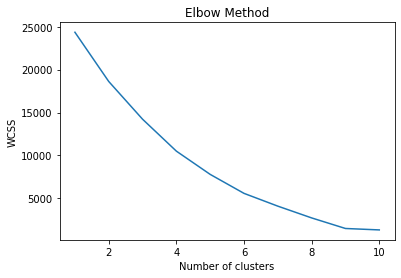

In [20]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() # showing plot from a prior tfidf

Looks like the optimal number would is the number of terms we have from tfidf. Brenden worked his plot using .score(). I would consider doing it his was to find the correct amount of clusters. 

In [39]:
from sklearn.cluster import KMeans

num_clusters = 9 #using num clusters from a prior term list.

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist() # The cluster is simply an array of non-negative integers 


Wall time: 26.6 s


In [40]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl') # saves results for km as a pickle document
km = joblib.load('doc_cluster.pkl') 
clusters = km.labels_.tolist() # Tells you what word, belongs to what group


In [41]:
data = { 'clusters' : clusters, 'words': content_clean }
frame = pd.DataFrame( data , index = [clusters] , columns = [ 'words' , 'clusters'] )
#created a frame than can classify the rows clean rows of df['content']

In [42]:
frame['clusters'].value_counts() #This tell you what each string, in df['content'] belongs to. 

7    18709
6     5895
4     4327
3     3548
5     3091
2     2561
0     2057
1     1861
8      887
Name: clusters, dtype: int64

In [44]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :9]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Top terms per cluster:

Cluster 0 words: b'drug', b'fentanyl', b'angel', b'overdose', b'killing', b'meth', b'makes', b'heroin', b'addiction',
Cluster 1 words: b'pain', b'morphine', b'codeine', b'amp', b'day', b'opioid', b'need', b'vicodin', b'just',
Cluster 2 words: b'crazy', b'codeine', b'codeine', b'future', b'songs', b'time', b'just', b'got', b'amp',
Cluster 3 words: b'codeine', b'got', b'drinking', b'like', b'just', b'amp', b'only', b'need', b'love',
Cluster 4 words: b'morphine', b'like', b'only', b'just', b'time', b'high', b'need', b'bad', b'heroin',
Cluster 5 words: b'percocet', b'stripper', b'joint', b'stripper', b'like', b'amp', b'got', b'just', b'fucked',
Cluster 6 words: b'fentanyl', b'china', b'heroin', b'overdose', b'died', b'meth', b'death', b'opioid', b'killing',
Cluster 7 words: b'oxycontin', b'vicodin', b'oxycodone', b'like', b'just', b'codeine', b'amp', b'say', b'opioid',
Cluster 8 words: b'wanted', b'percocet', b'just', b'don', b'morphine', b'codeine', b'fentanyl', b'

Should definetly consider getting rid of drug names, and fix the issue of "like" being included

# Multidimensional Scaling

Need to solve the $ 1 - cosine$ issue to progress. Find the elbow in our data using another method as mine suggests using the amount of terms n we have as clusters. In addition my tfidf will produce an error abount stop words... Which stack exhange initally said was do to accents. Any help will be greatly appreciated. 